In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#get train and test data, resize to 32x32 to fit LeNet (originally 28x28)
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))])
)

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))])
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
#define dataloaders 
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = training_data,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                           batch_size = batch_size,
                                           shuffle = True)

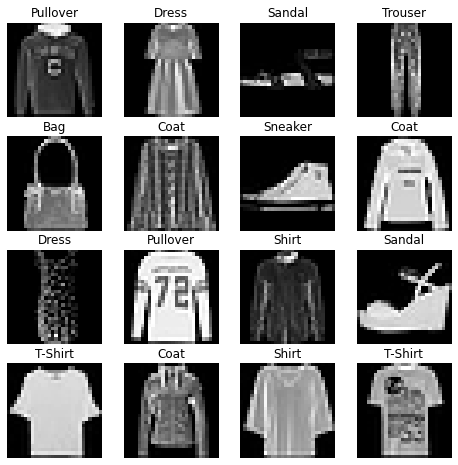

In [ ]:
#Visualize the dataset
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, 17):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
#build LeNet5 class with batch normalization
class LeNet5_bn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv1bn = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv1bn = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#Build LeNet5 dropout model
class LeNet5_dropout(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # add dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
#Build LeNet5 model with no changes
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#define a function that receives a model and optimizer and trains one epoch + returns accuracy
def train_one_epoch(model,optimizer,epoch,loss):
  model.train()
  total_loss = 0
  avg_loss = 0
  accuracy = 0
  nof_samples = 0
  correct_labeled_samples = 0
  for batch_idx, (inputs,labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    #forward pass and loss
    outputs = model(inputs)
    loss = cost(outputs,labels)
    

    #backprop & zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    correct_labeled_samples += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    nof_samples += len(inputs)
    accuracy = correct_labeled_samples / nof_samples
    avg_loss = total_loss / (batch_idx + 1)
    if (batch_idx+1) % 400 == 0:
      print(f'Loss: {avg_loss:.3f} | '
            f'Acc: {accuracy:.2f}[%] '
            f'({correct_labeled_samples}/{nof_samples})')
  return accuracy

In [ ]:
#define a function that evaluates trained model on test data and returns accuracy
def evaluate_model(model,optimizer,epoch,loss,data_loader):
  model.eval()
  total_loss = 0
  avg_loss = 0
  accuracy = nof_samples = 0
  correct_labeled_samples = 0
  for batch_idx, (inputs,labels) in enumerate(data_loader):
    with torch.no_grad():
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = cost(outputs,labels)
      total_loss += loss.item()
      correct_labeled_samples += (outputs.argmax(1) == labels).type(torch.float).sum().item()
      nof_samples += len(inputs)
      accuracy = correct_labeled_samples / nof_samples
      avg_loss = total_loss / (batch_idx + 1)
      if (batch_idx+1) % 400 == 0:
        print(f'Loss: {avg_loss:.3f} | '
              f'Acc: {accuracy:.2f}[%] '
              f'({correct_labeled_samples}/{nof_samples})')
  return accuracy


In [ ]:
#define a function that trains, evaluates, and logs all results for plotting 
def main(epochs,model,optimizer,model_name,loss):
  output_data = {"model": model_name,
                 "train_acc": [],
                 "test_acc":[],
                 }
  best_acc = 0
  for epoch in range(1, epochs + 1):
            print(f'Epoch {epoch}/{epochs}')

            train_acc = train_one_epoch(model,optimizer,epochs,loss)
            test_acc = evaluate_model(model,optimizer,epochs,loss,test_loader)
            if model_name == 'Dropout_Model':
              train_acc = evaluate_model(model,optimizer,epochs,loss,train_loader) #the dropout model is evaluated on train data in eval() mode so there is no dropout
            output_data["train_acc"].append(train_acc)
            output_data["test_acc"].append(test_acc)
            filename = model_name + '.json'
            if test_acc > best_acc:
              state = {
                    'model': model.state_dict(),
                    'train_acc': train_acc,
                    'test_acc': test_acc,
                    'epoch': epoch,
                }
              best_acc = test_acc
              torch.save(state, model_name + '.pt')
            with open(filename, 'w', encoding='utf-8') as f:
              json.dump(output_data, f, indent=4)


In [ ]:
#run main on regular model
#Define the first model
model1 = LeNet5().to(device) #the fashion mnist dataset has 10 classes-> 10 possible labels

#Define the loss function
cost = nn.CrossEntropyLoss()

#Define the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

main(15,model1,optimizer,'Regular_Model',cost)

Epoch 1/15
Loss: 0.821 | Acc: 0.70[%] (17859.0/25600)
Loss: 0.680 | Acc: 0.75[%] (38327.0/51200)
Epoch 2/15
Loss: 0.443 | Acc: 0.84[%] (21401.0/25600)
Loss: 0.430 | Acc: 0.84[%] (43172.0/51200)
Epoch 3/15
Loss: 0.373 | Acc: 0.86[%] (22019.0/25600)
Loss: 0.369 | Acc: 0.86[%] (44204.0/51200)
Epoch 4/15
Loss: 0.343 | Acc: 0.87[%] (22362.0/25600)
Loss: 0.336 | Acc: 0.88[%] (44839.0/51200)
Epoch 5/15
Loss: 0.315 | Acc: 0.88[%] (22586.0/25600)
Loss: 0.315 | Acc: 0.88[%] (45230.0/51200)
Epoch 6/15
Loss: 0.292 | Acc: 0.89[%] (22849.0/25600)
Loss: 0.291 | Acc: 0.89[%] (45745.0/51200)
Epoch 7/15
Loss: 0.280 | Acc: 0.90[%] (22980.0/25600)
Loss: 0.279 | Acc: 0.90[%] (45928.0/51200)
Epoch 8/15
Loss: 0.267 | Acc: 0.90[%] (23065.0/25600)
Loss: 0.265 | Acc: 0.90[%] (46132.0/51200)
Epoch 9/15
Loss: 0.252 | Acc: 0.91[%] (23209.0/25600)
Loss: 0.256 | Acc: 0.91[%] (46374.0/51200)
Epoch 10/15
Loss: 0.242 | Acc: 0.91[%] (23278.0/25600)
Loss: 0.243 | Acc: 0.91[%] (46550.0/51200)
Epoch 11/15
Loss: 0.223 | Acc

In [ ]:
#define model with dropout
model_dropout = LeNet5_dropout().to(device)
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=0.001)
main(15,model_dropout,optimizer,'Dropout_Model',cost)

Epoch 1/15
Loss: 0.814 | Acc: 0.69[%] (17766.0/25600)
Loss: 0.668 | Acc: 0.75[%] (38278.0/51200)
Loss: 0.426 | Acc: 0.84[%] (21527.0/25600)
Loss: 0.426 | Acc: 0.84[%] (43116.0/51200)
Epoch 2/15
Loss: 0.433 | Acc: 0.84[%] (21443.0/25600)
Loss: 0.415 | Acc: 0.85[%] (43291.0/51200)
Loss: 0.352 | Acc: 0.87[%] (22180.0/25600)
Loss: 0.355 | Acc: 0.87[%] (44365.0/51200)
Epoch 3/15
Loss: 0.358 | Acc: 0.87[%] (22174.0/25600)
Loss: 0.356 | Acc: 0.87[%] (44445.0/51200)
Loss: 0.316 | Acc: 0.88[%] (22538.0/25600)
Loss: 0.312 | Acc: 0.88[%] (45188.0/51200)
Epoch 4/15
Loss: 0.330 | Acc: 0.88[%] (22460.0/25600)
Loss: 0.326 | Acc: 0.88[%] (45066.0/51200)
Loss: 0.282 | Acc: 0.90[%] (22956.0/25600)
Loss: 0.283 | Acc: 0.90[%] (45841.0/51200)
Epoch 5/15
Loss: 0.300 | Acc: 0.89[%] (22772.0/25600)
Loss: 0.302 | Acc: 0.89[%] (45471.0/51200)
Loss: 0.258 | Acc: 0.90[%] (23145.0/25600)
Loss: 0.259 | Acc: 0.90[%] (46244.0/51200)
Epoch 6/15
Loss: 0.293 | Acc: 0.89[%] (22842.0/25600)
Loss: 0.288 | Acc: 0.89[%] (457

In [ ]:
#define model with batch-norm
model_bn = LeNet5_bn().to(device)
optimizer = torch.optim.Adam(model_bn.parameters(), lr=0.001)
main(15,model_bn,optimizer,'BN_Model',cost)

Epoch 1/15
Loss: 0.807 | Acc: 0.70[%] (17824.0/25600)
Loss: 0.670 | Acc: 0.75[%] (38160.0/51200)
Epoch 2/15
Loss: 0.435 | Acc: 0.84[%] (21453.0/25600)
Loss: 0.413 | Acc: 0.85[%] (43324.0/51200)
Epoch 3/15
Loss: 0.361 | Acc: 0.87[%] (22159.0/25600)
Loss: 0.353 | Acc: 0.87[%] (44482.0/51200)
Epoch 4/15
Loss: 0.321 | Acc: 0.88[%] (22543.0/25600)
Loss: 0.317 | Acc: 0.88[%] (45232.0/51200)
Epoch 5/15
Loss: 0.294 | Acc: 0.89[%] (22859.0/25600)
Loss: 0.297 | Acc: 0.89[%] (45620.0/51200)
Epoch 6/15
Loss: 0.287 | Acc: 0.89[%] (22857.0/25600)
Loss: 0.284 | Acc: 0.89[%] (45772.0/51200)
Epoch 7/15
Loss: 0.268 | Acc: 0.90[%] (23068.0/25600)
Loss: 0.267 | Acc: 0.90[%] (46116.0/51200)
Epoch 8/15
Loss: 0.255 | Acc: 0.91[%] (23172.0/25600)
Loss: 0.254 | Acc: 0.91[%] (46371.0/51200)
Epoch 9/15
Loss: 0.243 | Acc: 0.91[%] (23306.0/25600)
Loss: 0.244 | Acc: 0.91[%] (46550.0/51200)
Epoch 10/15
Loss: 0.235 | Acc: 0.91[%] (23355.0/25600)
Loss: 0.236 | Acc: 0.91[%] (46696.0/51200)
Epoch 11/15
Loss: 0.224 | Acc

In [ ]:
#calculate accuracy for weight decay
model_wd = LeNet5().to(device) 
optimizer_wd = torch.optim.Adam(model_wd.parameters(), lr=0.001, weight_decay=0.001)  # add weight_decay parameter
main(15,model_wd,optimizer_wd,'Weight_Decay_Model',cost)

Epoch 1/15
Loss: 0.777 | Acc: 0.70[%] (17969.0/25600)
Loss: 0.642 | Acc: 0.76[%] (38662.0/51200)
Epoch 2/15
Loss: 0.425 | Acc: 0.84[%] (21568.0/25600)
Loss: 0.410 | Acc: 0.85[%] (43451.0/51200)
Epoch 3/15
Loss: 0.367 | Acc: 0.87[%] (22166.0/25600)
Loss: 0.360 | Acc: 0.87[%] (44452.0/51200)
Epoch 4/15
Loss: 0.331 | Acc: 0.88[%] (22509.0/25600)
Loss: 0.332 | Acc: 0.88[%] (44906.0/51200)
Epoch 5/15
Loss: 0.322 | Acc: 0.88[%] (22558.0/25600)
Loss: 0.318 | Acc: 0.88[%] (45246.0/51200)
Epoch 6/15
Loss: 0.309 | Acc: 0.89[%] (22660.0/25600)
Loss: 0.306 | Acc: 0.89[%] (45365.0/51200)
Epoch 7/15
Loss: 0.291 | Acc: 0.89[%] (22789.0/25600)
Loss: 0.296 | Acc: 0.89[%] (45602.0/51200)
Epoch 8/15
Loss: 0.283 | Acc: 0.90[%] (22931.0/25600)
Loss: 0.286 | Acc: 0.89[%] (45812.0/51200)
Epoch 9/15
Loss: 0.274 | Acc: 0.90[%] (22977.0/25600)
Loss: 0.278 | Acc: 0.90[%] (45900.0/51200)
Epoch 10/15
Loss: 0.270 | Acc: 0.90[%] (23014.0/25600)
Loss: 0.268 | Acc: 0.90[%] (46084.0/51200)
Epoch 11/15
Loss: 0.260 | Acc

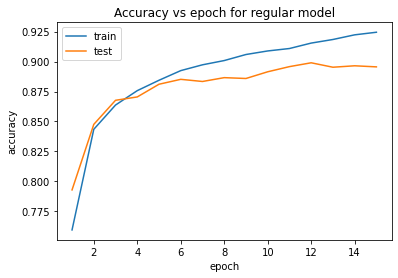

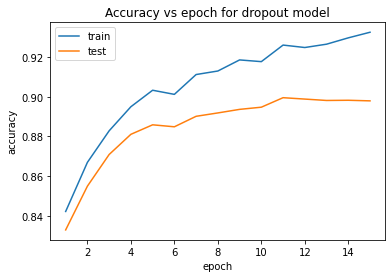

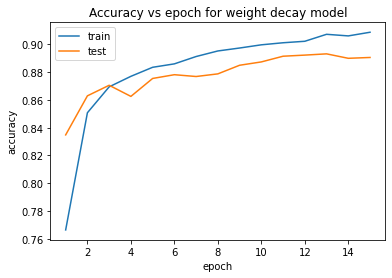

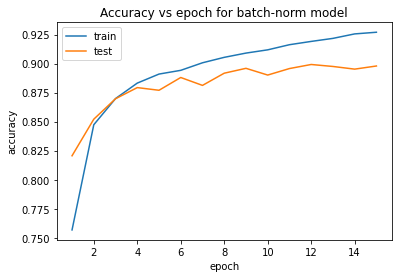

In [ ]:
#plot accuracy from json files
summary = {'Regular Model' : [],
           'Dropout Model': [],
           'Weight Decay Model': [],
           'Batch-norm Model':[]}
with open('Regular_Model.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_regular_model = plt.figure()
plt.plot(range(1, len(results_dict['train_acc']) + 1),
             results_dict['train_acc'])
plt.plot(range(1, len(results_dict['test_acc']) + 1),
             results_dict['test_acc'])
plt.legend(['train','test'])
plt.title('Accuracy vs epoch for regular model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
accuracies_regular_model.savefig('Regular_model_accuracies_plot.png')
plt.show()
summary['Regular Model'].append(max(results_dict['train_acc']))
summary['Regular Model'].append(max(results_dict['test_acc']))

with open('Dropout_Model.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_dropout_model = plt.figure()
plt.plot(range(1, len(results_dict['train_acc']) + 1),
             results_dict['train_acc'])
plt.plot(range(1, len(results_dict['test_acc']) + 1),
             results_dict['test_acc'])
plt.legend(['train','test'])
plt.title('Accuracy vs epoch for dropout model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
accuracies_dropout_model.savefig('Dropout_model_accuracies_plot.png')
plt.show()
summary['Dropout Model'].append(max(results_dict['train_acc']))
summary['Dropout Model'].append(max(results_dict['test_acc']))

with open('Weight_Decay_Model.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_wd_model = plt.figure()
plt.plot(range(1, len(results_dict['train_acc']) + 1),
             results_dict['train_acc'])
plt.plot(range(1, len(results_dict['test_acc']) + 1),
             results_dict['test_acc'])
plt.legend(['train','test'])
plt.title('Accuracy vs epoch for weight decay model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
accuracies_wd_model.savefig('Weight_Decay_Model_accuracies_plot.png')
plt.show()
summary['Weight Decay Model'].append(max(results_dict['train_acc']))
summary['Weight Decay Model'].append(max(results_dict['test_acc']))

with open('BN_Model.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_bn_model = plt.figure()
plt.plot(range(1, len(results_dict['train_acc']) + 1),
             results_dict['train_acc'])
plt.plot(range(1, len(results_dict['test_acc']) + 1),
             results_dict['test_acc'])
plt.legend(['train','test'])
plt.title('Accuracy vs epoch for batch-norm model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
accuracies_bn_model.savefig('Batch_Norm_Model_accuracies_plot.png')
plt.show()
summary['Batch-norm Model'].append(max(results_dict['train_acc']))
summary['Batch-norm Model'].append(max(results_dict['test_acc']))

In [ ]:
print("{:<20} {:<20} {:<20}".format('MODEL', 'TRAIN', 'TEST'))
 
#print max train and test accuracy for each model
for key, value in summary.items():
    train,test = value
    print("{:<20} {:<20} {:<20}".format(key, train,test))

MODEL                TRAIN                TEST                
Regular Model        0.9245               0.899               
Dropout Model        0.9326666666666666   0.8996              
Weight Decay Model   0.90865              0.8931              
Batch-norm Model     0.9269666666666667   0.8992              
